<a href="https://colab.research.google.com/github/parkdoyun/google_colab/blob/master/Project_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ctrl+f9 -> 모두 실행
# ctrl+f10 -> 이후 셀 실행

# google 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install face_recognition

     |████████████████████████████████| 100.1 MB 9.8 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=b038e7875cb7484db6682370c6380f53f94a3b94ef1f4ef70a51ad69e434bc9f
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
# 웹캠 사진 출력 함수 take_photo()
# 캡처 버튼 누르면 -> 'photo.jpg'로 저장
# ctrl+f10 -> 이후 셀 실행

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


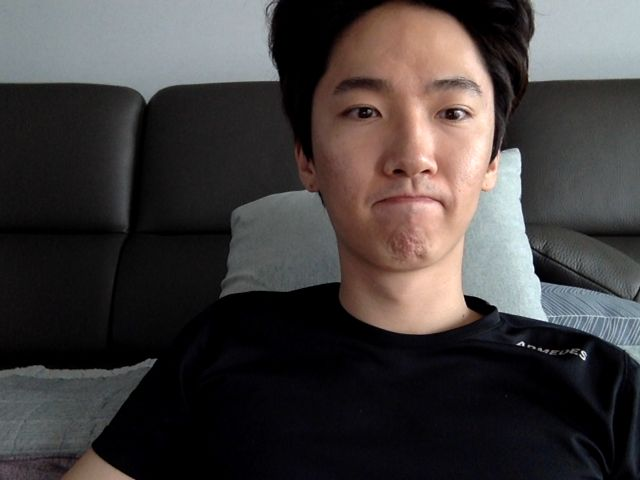

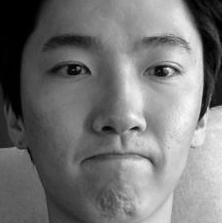

-1

In [ ]:
# 웹캠으로 사진 찍어서 얼굴 부분만 크롭
# 해당 이미지 저장하기 (photo_trim.jpg)

import cv2
import numpy as np
import face_recognition
from google.colab.patches import cv2_imshow

# 사진 찍기
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# 사진에 네모박스 치기
import cv2
import numpy as np
import face_recognition

img1 = face_recognition.load_image_file('photo.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

# face_recognition이 검출한 얼굴의 위치 가져옴
# 한 이미지에 사람 많다면 각 구역에 대한 위치 반환

faceLoc = face_recognition.face_locations(img1)[0]
encodeImg1 = face_recognition.face_encodings(img1)[0] # 얼굴 구역 내 세밀한 특징 인코딩
# 특징 많이 보유 -> 그 사람이라 판단, 다른 사진들도 학습 & 예측 가능
# cv2.rectangle(img1, (faceLoc[3], faceLoc[0]), (faceLoc[1], faceLoc[2]), (255, 0, 255), 2) # 사각형 얼굴에 표시
# cv2.rectangle(사진, start_point(시작점 x, y), end_point, color, thickness)

# cv2_imshow(img1) # 사진 출력

# 이미지 얼굴 부분 자르고 따로 저장
x = faceLoc[3]; y = faceLoc[0] # 자르고 싶은 지점의 x좌표, y좌표
w = abs(faceLoc[1]-faceLoc[3]); h = abs(faceLoc[2]-faceLoc[0]) # x로부터 width, y로부터 height 지정

# 크롭 범위 확대
# x = int(x / 1.8); y = int(y / 1.8)
# w = int(w * 1.8); h = int(h * 1.8)

img_trim = img1[y:y + h, x:x+w] # trim한 결과를 img_trim에 넣는다
cv2.imwrite('photo_trim.jpg', img_trim) # 저장

img_trim = cv2.imread('photo_trim.jpg', cv2.IMREAD_GRAYSCALE) # 흑백 처리해서 다시 불러옴
cv2_imshow(img_trim) # display

cv2.imwrite('photo_trim.jpg', img_trim) # 흑백으로 다시 저장

cv2.waitKey(0)

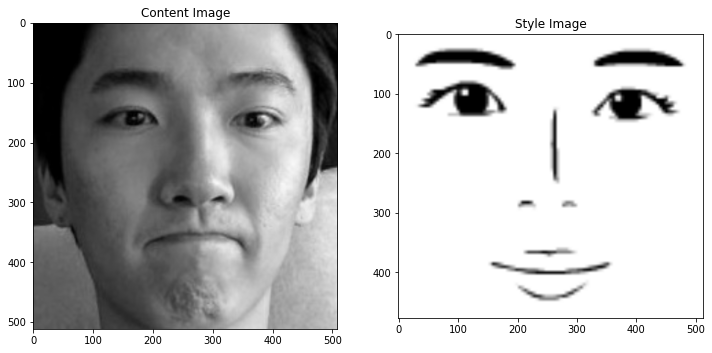

In [ ]:
# Neural Style Transfer 시작

import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# 스타일 참조 이미지와 콘텐츠 이미지 선택

# 이미지 다운로드 함수
content_path = 'photo_trim.jpg' # 자르고 생성한 사진
style_path = '/content/drive/MyDrive/Colab_Notebooks/face_style3.png' # 스타일 사진
# style_path = '/content/drive/MyDrive/Colab_Notebooks/face_style2.jpg'

# 입력 시각화
# 이미지 불러오는 함수 정의, 최대 이미지 크기를 512개의 픽셀로 제한
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

# 이미지 출력 위한 함수 정의
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
  
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')



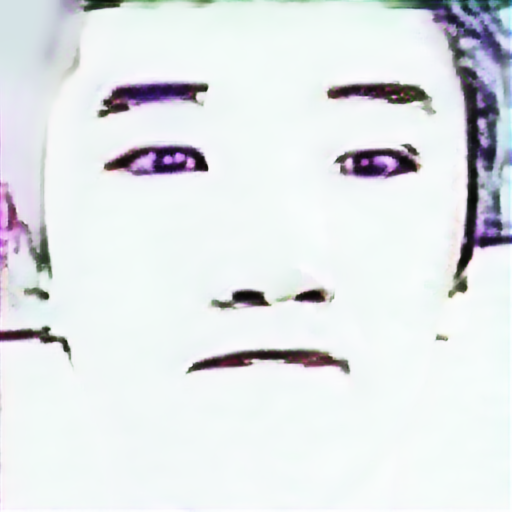

In [ ]:
# tf-hub 통한 빠른 스타일 전이 시험 코드

import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image),  tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [ ]:
# 콘텐츠와 스타일 표현 정의
# 모델의 몇가지 중간층 살펴봄
# 입력층부터 ~> 처음 몇개 층 : 저차원적 특성에 반응 (선분, 질감..)
# 네트워크가 깊어질수록 ~> 최종 몇개 층 : 고차원적 특성에 반응 (바퀴, 눈..)
# VGG19 네트워크 구조 사용 : 사전학습된 이미지 분류 네트워크
# 입력 이미지 주어지면 -> 스타일 전이 알고리즘은 이 중간층에서 content_img와 style_img 해당하는 타깃 표현 일치시키려고 시도함

# VGG19 모델 불러오고, 작동 여부 확인 위해 이미지에 적용
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

# 분류층 제외한 VGG19 모델 불러오고, 각 층의 이름 출력
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
"""
print()
for layer in vgg.layers:
  print(layer.name)
"""
# 이미지의 스타일과 콘텐츠 나타내기 위한 모델의 중간층 선택
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
# 스타일과 콘텐츠를 위한 중간층
# 중간 출력으로 어떻게 스타일과 콘텐츠 표현 정의?
# 고수준 이미지 분류 -> 네트워크가 반드시 이미지 이해해야 함
# 미가공 이미지 -> [이미지 내 특성들에 대한 복합적 이해로 변환]할 수 있는 내부 표현 만드는 작업 포함
# 합성곱 신경망의 일반화 쉽게 가능 -> 노이즈에 상관없이 불변성과 특징 포착 가능
# 모델은 출력 중간 어딘가에서 복합 특성 추출기 역할 수행
# 모델의 중간층 접근 -> 입력 이미지의 콘텐츠와 스타일 추출


In [ ]:
# 모델 만들기
# tf.keras.applications 제공 모델 -> 중간층에 쉽게 접근 가능
# 모델 정의하려면 -> 모델의 입출력 지정
# model = Model(inputs, outputs)

# 결과 배열로 출력하는 VGG19 model return
def vgg_layers(layer_names):
  # 이미지넷 데이터셋에 사전학습된 VGG 모델 불러옴
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# 각 층의 출력에 대한 통계량
"""
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("크기 " , output.numpy().shape)
  print("최솟값 " , output.numpy().min())
  print("최댓값 " , output.numpy().max())
  print("평균 " , output.numpy().mean)
  print()
"""

'\nfor name, output in zip(style_layers, style_outputs):\n  print(name)\n  print("크기 " , output.numpy().shape)\n  print("최솟값 " , output.numpy().min())\n  print("최댓값 " , output.numpy().max())\n  print("평균 " , output.numpy().mean)\n  print()\n'

In [ ]:
import tensorflow as tf

# 스타일 계산
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

# 스타일과 콘텐츠 추출
# 스타일과 콘텐츠 텐서 반환하는 모델 생성
# StyleContentModel 클래스 생성
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs): # 0~1 사이 실수 입력
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    
    style_outputs = [gram_matrix(style_output)
                    for style_output in style_outputs]

    content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

# 이미지 입력으로 주어졌을 때, style_layers의 스타일과 content_layers의 콘텐츠에 대한 그람 행렬 출력
# 추출기
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))
"""
print('style')
for name, output in sorted(results['style'].items()):
  print(" ", name)
  print("  크기 ", output.numpy().shape)
  print("  최솟값 ", output.numpy().shape)
  print("  최댓값 ", output.numpy().shape)
  print("  평균 ", output.numpy().shape)
  print()

print('content')
for name, output in sorted(results['content'].items()):
  print(" ", name)
  print("  크기 ", output.numpy().shape)
  print("  최솟값 ", output.numpy().shape)
  print("  최댓값 ", output.numpy().shape)
  print("  평균 ", output.numpy().shape)
  print()
"""


'\nprint(\'style\')\nfor name, output in sorted(results[\'style\'].items()):\n  print(" ", name)\n  print("  크기 ", output.numpy().shape)\n  print("  최솟값 ", output.numpy().shape)\n  print("  최댓값 ", output.numpy().shape)\n  print("  평균 ", output.numpy().shape)\n  print()\n\nprint(\'content\')\nfor name, output in sorted(results[\'content\'].items()):\n  print(" ", name)\n  print("  크기 ", output.numpy().shape)\n  print("  최솟값 ", output.numpy().shape)\n  print("  최댓값 ", output.numpy().shape)\n  print("  평균 ", output.numpy().shape)\n  print()\n'

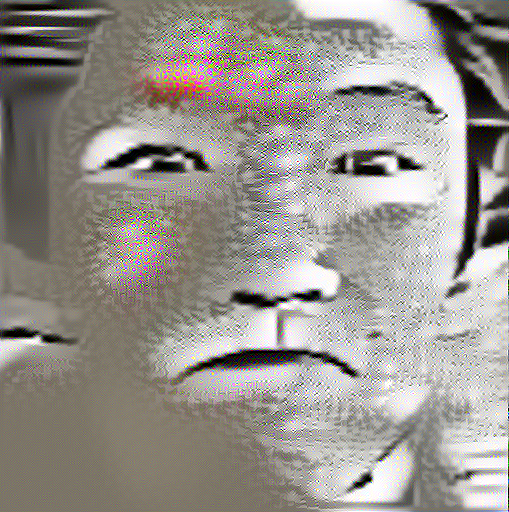

훈련 스텝 : 1000
전체 소요 시간 : 329.3


In [ ]:
# 경사하강법 실행
# 스타일과 콘텐츠 추출기로 스타일 전이 알고리즘 구현
# 타깃에 대한 입력 이미지의 평균 제곱 오차 계산, 오차값들의 가중합 구함

# 스타일과 콘텐츠의 타깃값 지정
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# 최적화시킬 이미지를 담을 tf.Variable 정의, 콘텐츠 이미지로 초기화
# ***이때 tf.Variable은 콘텐츠 이미지와 크기 동일해야 함!! ***

image = tf.Variable(content_image)

# 픽셀 값 -> 실수이므로 0~1 사이로 클리핑(범위 제한)
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)

# 옵티마이저 생성
opt = tf.optimizers.Adam(learning_rate = 0.02, beta_1 = 0.99, epsilon = 1e-1)

# 전체 오차 = 콘텐츠와 스타일 오차의 가중합
style_weight = 1e-2
content_weight = 1e4

def style_content_loss(outputs): # 콘텐츠와 스타일 오차의 가중합
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
  for name in style_outputs.keys()])

  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
  for name in content_outputs.keys()])

  content_loss *= content_weight / num_content_layers
  loss = style_loss + content_loss
  return style_loss

# tf.GradientTape 사용해 이미지 업데이트
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

# 최적화 진행
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝 : {}".format(step))

end = time.time()
print("전체 소요 시간 : {:.1f}".format(end-start))


array([164385.69], dtype=float32)

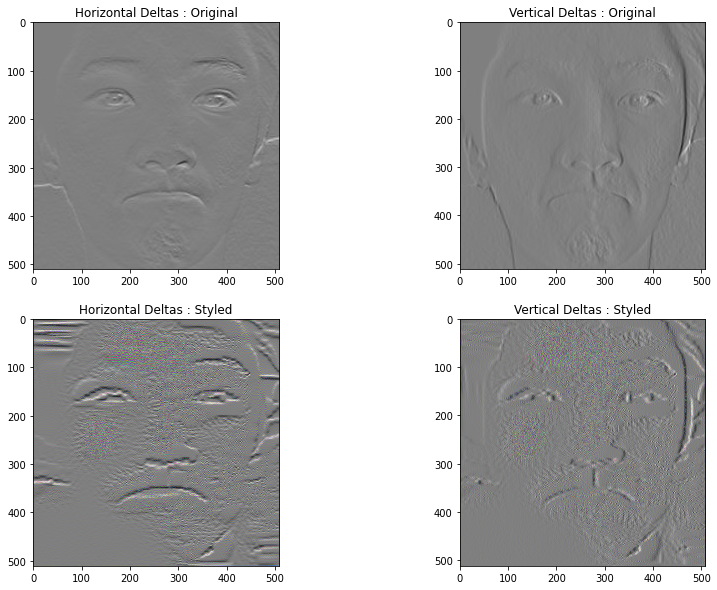

In [ ]:
# 총 변위 손실 (total variation loss)
# 이 구현 방식의 단점 : 많은 high frequency artifact(고주파 아티팩, 고주파 인공물)이 생겨남
# 아티팩 생성 줄이기 위해 -> 이미지의 고주파 구성 요소에 대한 regularization(정규화) 수행
# 이 변형된 오차값 : 총 변위 손실

def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas : Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas : Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas : Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas : Styled")

# 위 이미지들 -> 고주파 구성 요소가 늘어났다는 것 보여줌
# 고주파 구성 요소 =  경계선 탐지기 일종
# Sobel edge detector(소벨 경계선 탐지기) 이용하면 위와 유사한 출력 얻을 수 있음

"""
plt.figure(figsize=(14, 10))
sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")

plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")
"""

# 정규화 오차 -> 각 값의 절대값의 합
# 이거 구현할 필요 X -> 텐서플로에 내장
"""
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_loss(image).numpy()
"""

tf.image.total_variation(image).numpy()

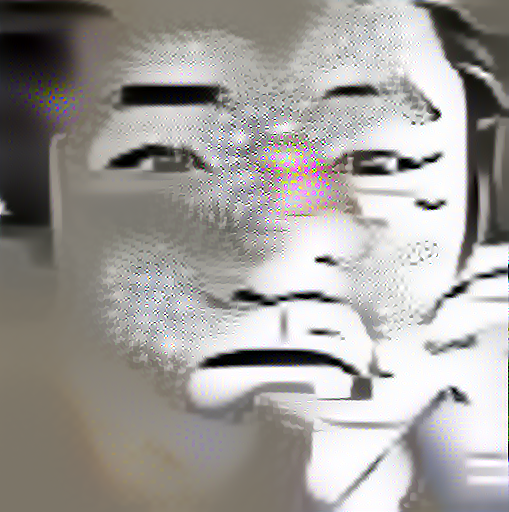

훈련 스텝 : 1000
전체 소요 시간 : 324.8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 최적화
# total_variation_loss 위한 가중치 정의
total_variation_weight = 30

# 가중치를 train_step()에서 사용
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight * tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

# 최적화 변수를 다시 초기화
image = tf.Variable(content_image)

# 최적화 수행
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝 : {}".format(step))

end = time.time()
print("전체 소요 시간 : {:.1f}".format(end-start))

# 결과물 파일 저장
file_name = 'photo_complete.jpg'
tensor_to_image(image).save(file_name)

# PC 저장
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(file_name)

